In [35]:
import tsfresh
from tsfresh import feature_selection
from tsfresh import extract_features, select_features
import os
import warnings
from abc import ABC
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from collections import Counter
import torch.nn as nn
import gc
import time
import torch
import numpy as np
import random
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import math
import pywt
from math import log
from tsfresh.feature_extraction import MinimalFCParameters,EfficientFCParameters
from tsfresh import feature_extraction
from tsfresh import extract_features
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.decomposition import PCA
import tsfresh
from tsfresh import feature_selection
from tsfresh import extract_features, select_features
from utilities import *
from scipy.signal import savgol_filter

# 读取原始数据(以某个文件为例)

In [28]:
DATA_PATH = "../Datasets/sit-ups/"
attribute = ["Time","og1","og2","og3","ag1","ag2","ag3","ac1","ac2","ac3"]
sit_up_1 = pd.read_csv(DATA_PATH + "lefthand_abnormal_1.csv",names=attribute, header=None)

In [29]:
sit_up_1.head()

,Time,og1,og2,og3,ag1,ag2,ag3,ac1,ac2,ac3
0,0.144998,0.000000,0.000000,0.0,-174.825439,4.795532,11.672974,0.000000,0.000000,0.000000
1,0.144998,0.183105,0.427246,0.0,-174.819946,4.790039,11.672974,-0.082520,-0.089355,-0.993164
2,0.145228,0.183105,0.122070,0.0,-174.819946,4.784546,11.672974,-0.081543,-0.089355,-0.991699
3,0.145228,0.183105,0.122070,0.0,-174.819946,4.784546,11.672974,-0.081543,-0.089355,-0.991699
4,0.145228,0.000000,0.000000,0.0,-174.819946,4.784546,11.672974,-0.082520,-0.089844,-0.991699


# 切割

In [30]:
# 第一个样本为例

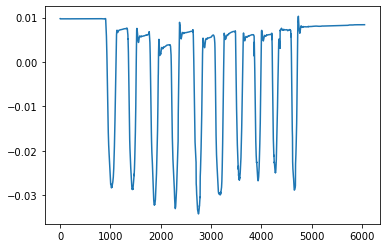

In [36]:
m1 = get_major_frequency(sit_up_1.iloc[:,1:])
plt.plot(m1)

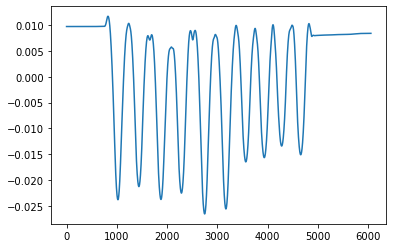

In [41]:
tmp_smooth = savgol_filter(m1,305,3) #501是平滑参数 越大平滑越多
plt.plot(tmp_smooth)

In [42]:
start_list3,end_list3 = get_raw_start_end_list(tmp_smooth,lim_a=-0.0001,lim_b=0.0001)
start_list_edit3 = get_start_edit(start_list3)
end_listd_edit3 = get_end_edit(end_list3)

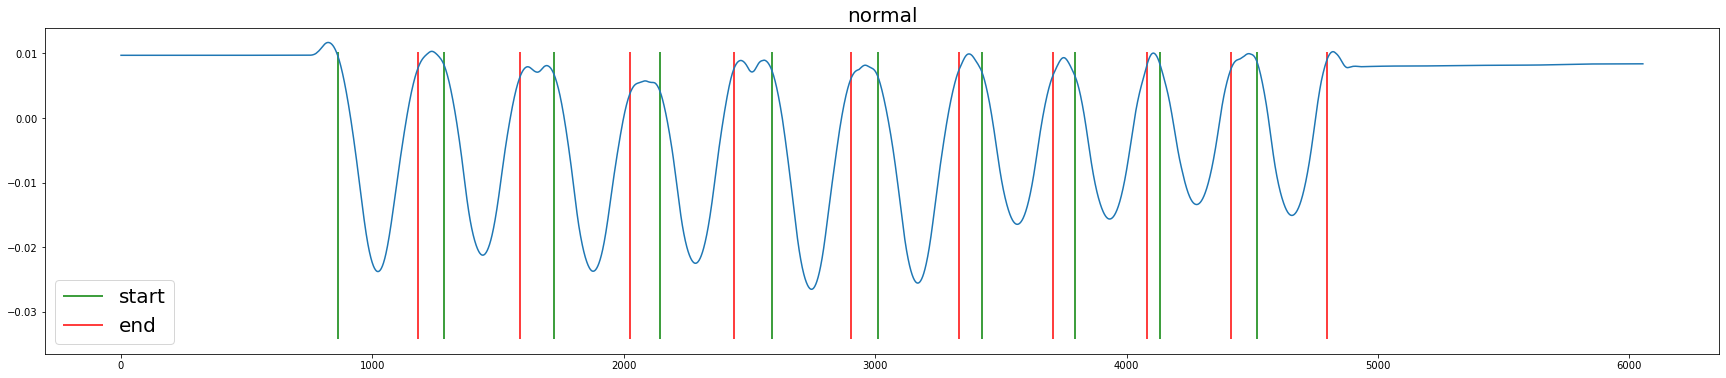

In [44]:
plt.figure(figsize=(30,6))
#plt.plot(d_signal,"pink")
plt.plot(tmp_smooth)
plt.vlines(start_list_edit3,np.min(m1),np.max(m1),color = "g",label='start')
plt.vlines(end_listd_edit3,np.min(m1),np.max(m1),color = "red",label = 'end')
plt.legend(fontsize = 20)
plt.title("normal",fontsize = 20)
plt.show()

In [83]:
#如何切割
assert len(start_list_edit3) == len(end_listd_edit3)
slice_list = []
for i in range(len(start_list_edit3)):
    nb1 = sit_up_1.iloc[start_list_edit3[i]:end_listd_edit3[i]]
    nb1_ = nb1.copy()
    nb1_.loc[:,"Time"] = np.arange(1,nb1.shape[0]+1)
    nb1_.reset_index(drop = True)
    slice_list.append(nb1_)

sliced_sample = pd.concat(slice_list)
sliced_sample["label"] = 0
sliced_sample
    
    

,Time,og1,og2,og3,ag1,ag2,ag3,ac1,ac2,ac3,label
863,1,0.488281,-0.793457,0.000000,-174.957275,4.773560,11.700439,-0.080566,-0.088379,-0.997559,0
864,2,0.488281,-0.793457,0.000000,-174.951782,4.784546,11.700439,-0.080566,-0.088379,-0.997559,0
865,3,0.488281,-1.281738,0.000000,-174.946289,4.795532,11.700439,-0.083496,-0.087891,-0.996582,0
866,4,0.488281,-1.281738,0.000000,-174.940796,4.806519,11.705933,-0.083496,-0.087891,-0.996582,0
867,5,0.488281,-0.427246,0.000000,-174.935303,4.812012,11.705933,-0.084961,-0.087402,-0.997070,0
...,...,...,...,...,...,...,...,...,...,...,...
4794,277,0.305176,1.953125,0.000000,-167.986450,9.448242,78.931274,-0.155273,-0.161133,-1.007324,0
4795,278,-1.892090,-2.014160,0.549316,-168.019409,9.475708,78.695068,-0.154785,-0.162598,-1.002930,0
4796,279,-1.892090,-2.014160,0.549316,-168.057861,9.503174,78.453369,-0.154785,-0.162598,-1.002930,0
4797,280,-3.417969,-4.638672,0.854492,-168.107300,9.558105,78.217163,-0.156250,-0.156250,-0.985352,0


# 定义一个函数，输入为地址，再获得sliced_sample

In [89]:
def raw_csv_to_sliced_sample(file,label,DATA_PATH = "../Datasets/sit-ups/"):
    attribute = ["Time","og1","og2","og3","ag1","ag2","ag3","ac1","ac2","ac3"]
    sit_up_1 = pd.read_csv(DATA_PATH + file,
                           names=attribute, header=None)
    m1 = get_major_frequency(sit_up_1.iloc[:,1:])
    tmp_smooth = savgol_filter(m1,305,3)
    start_list3,end_list3 = get_raw_start_end_list(tmp_smooth,lim_a=-0.0001,lim_b=0.0001)
    start_list_edit3 = get_start_edit(start_list3)
    end_listd_edit3 = get_end_edit(end_list3)
    assert len(start_list_edit3) == len(end_listd_edit3)
    slice_list = []
    for i in range(len(start_list_edit3)):
        nb1 = sit_up_1.iloc[start_list_edit3[i]:end_listd_edit3[i]]
        nb1_ = nb1.copy()
        nb1_.loc[:,"Time"] = np.arange(1,nb1.shape[0]+1)
        nb1_.reset_index(drop = True)
        slice_list.append(nb1_)
    sliced_sample = pd.concat(slice_list)
    sliced_sample["label"] = label # 0是不标准。1是标准
    return sliced_sample.reset_index(drop = True)
    

In [90]:
raw_csv_to_sliced_sample("lefthand_normal_1.csv",1)

,Time,og1,og2,og3,ag1,ag2,ag3,ac1,ac2,ac3,label
0,1,-0.366211,-0.976562,0.000000,-171.666870,1.702881,-72.828369,-0.030273,-0.144043,-0.992188,1
1,2,-0.366211,-0.976562,0.000000,-171.672363,1.713867,-72.822876,-0.030273,-0.144043,-0.992188,1
2,3,-0.610352,-0.122070,0.000000,-171.677856,1.719360,-72.822876,-0.029297,-0.144531,-0.996094,1
3,4,-0.610352,-0.122070,0.000000,-171.683350,1.719360,-72.822876,-0.029297,-0.144531,-0.996094,1
4,5,-0.854492,-0.061035,0.000000,-171.688843,1.719360,-72.822876,-0.027344,-0.146484,-1.004883,1
...,...,...,...,...,...,...,...,...,...,...,...
4149,404,-5.004883,2.258301,-0.061035,-174.078369,3.889160,100.865479,-0.022949,-0.090820,-0.910156,1
4150,405,0.305176,1.403809,0.000000,-174.078369,3.861694,100.870972,-0.021973,-0.088379,-0.934570,1
4151,406,0.305176,1.403809,0.000000,-174.072876,3.828735,100.870972,-0.021973,-0.088379,-0.934570,1
4152,407,3.662109,1.281738,0.244141,-174.039917,3.801270,100.870972,-0.020508,-0.093750,-0.976562,1
